# Learn v75 med walkthrough-metoden

In [48]:
import pandas as pd 
import numpy as np 
from catboost import CatBoostClassifier,Pool,cv,utils
import pickle
import sys
sys.path.append('C:\\Users\peter\\Documents\\MyProjects\\PyProj\\Trav\\spel')
import V75_scraping as vs


In [2]:

def proba_order_score(df_, y, proba):  # df skall innehålla datum,avd,vodds
    kassa=1000
    df = df_.copy()
    df['proba'] = proba[:,1]
    df['f'] = (df.proba*df.vodds - 1) / (df.vodds-1)  # kelly formel
    df['spela'] = df.f >0
    df['insats'] = df.spela * df.f * kassa

    df.sort_values(['datum','avd','proba'],ascending=[True,True,False],inplace=True)
    proba_order=df.groupby(['datum','avd']).proba.cumcount()

    df['prob_order']=proba_order+1
    df['y'] = y

    print('log(proba)',np.log(df.loc[df.y==1].proba).mean())
    return df, df.loc[df.y==1].prob_order.mean()   # mean prob_order för vinnarhäst


In [3]:
def create_ekipage(df_):
    df=df_.copy()
    prefs = ['','h1_','h2_','h3_','h4_','h5_',]
    for pr in prefs:
        df[pr+'ekipage'] = df[pr+'kusk'].str.cat(df['häst'], sep =", ")
        df.drop([pr+'kusk'],axis=1, inplace=True)
        
    return df.drop(['häst'], axis=1)

In [4]:
### returnera en modell med parametrar satta
def get_model(d=6,l2=2,iterations=3000,use_best=True,verbose=False):
    model = CatBoostClassifier(iterations=iterations,use_best_model=use_best, 
        custom_metric=['Logloss', 'AUC','Recall', 'Precision', 'F1', 'Accuracy'],

        eval_metric='Accuracy', 
        depth=d,l2_leaf_reg=l2,
        auto_class_weights='Balanced',verbose=verbose, random_state=2021) 
    return model                

In [5]:
### Features som inte används vid träning
def remove_features(df_,remove_mer=[]):
    # df = df_.copy()
    #remove_mer=['h5_perf','h5_auto','h4_perf','h4_auto', 'h3_perf', 'h2_perf']
    df = df_.drop(['avd','startnr','vodds','podds','bins','h1_dat','h2_dat','h3_dat','h4_dat','h5_dat'],axis=1) #
    if remove_mer:
        df = df.drop(remove_mer,axis=1)
    
    # df=check_unique(df.copy())
    # df=check_corr(df.copy())
    return df

In [6]:
 ## byt ut alla NaN till text för cat_features
def replace_NaN(X_train,X_test=None, cat_features=[]):
    # print('cat_features',cat_features)
    for c in cat_features:
        # print(c)
        X_train.loc[X_train[c].isna(),c] = 'None'       ### byt ut None-värden till texten 'None
        if X_test is not None:  ## om X_test är med
            X_test.loc [X_test[c].isna(),c] = 'None'    ### byt ut None-värden till texten 'None

    return X_train,X_test

In [7]:
def scrape_nya_lopp():
    """scrape nya lopp och lägg in i all_data.csv"""
    nya_lopp,strukna = vs.v75_scraping(resultat=True,history=True)

    df=pd.concat([pd.read_csv('all_data.csv'), nya_lopp])
    print('shape med nya lopp',df.shape)
    #ta bort dubletter
    df.drop_duplicates(['datum','avd','häst'],inplace=True)
    df.sort_values(by=['datum','avd'],inplace=True)
    df.reset_index(drop=True,inplace=True)
    print('shape med dubletter bort',df.shape)

    df.to_csv('all_data.csv', index=False)

    print("första datum i df =",df.datum.head(1).to_list()[0])
    print("sista  datum i df =",df.datum.tail(1).to_list()[0])

    return df,nya_lopp

In [8]:
### beräkna vilka datum att använda ###
def get_alla_datum(test_from_proc=0.75, train_from_proc=0, total_omlärning = False):
    if total_omlärning:
        nya_lopp=None
        df = pd.read_csv('all_data.csv')     
        datum_att_lära = df.datum.unique()
        split_ix = int(len(datum_att_lära)*test_from_proc)
    else:
        # normalt adderar vi bara 1 eller flera veckor från "omg_att_spela_link.csv"
        df, nya_lopp = scrape_nya_lopp()  # scrape från 'omg_att_spela_link.csv' och addera till df
        omg_df = pd.read_csv('omg_att_spela_link.csv')     
        startix=omg_df.Link.str.find('spel')[0]    # index till 'spel' i url
        datum_att_lära = omg_df.Link.str.slice(start=startix+5,stop=startix+15).to_list() # en datum 
        split_ix=0
        print(f'datum att lära: {datum_att_lära}')

    return df,nya_lopp,datum_att_lära,split_ix


## Walkthrough-funktionen  här

In [9]:

### Kör en walkthrough learn här, en datum i taget framåt

# Jag har ändrat till att alla steg kör utan test-datam ed fast iterations=100
def walkthrough(classic_test=False, verbose=False):
    
    df, nya_lopp, alla_datum, split_ix = get_alla_datum(0.8)

    l2_leaf_regs=2
    model=get_model(use_best=False,iterations=100)
    df=remove_features(df.copy())
    cat_features = list(df.loc[:,df.dtypes=='O'].columns)
    df,_ = replace_NaN(df.copy(), cat_features=cat_features)    
    print(f'cat_features {cat_features}\n')

    df['plac']=(df.plac==1)*1
        
    for nr,datum in enumerate(alla_datum[split_ix:]):
        print(f'walk-iter {nr+1} av {len(alla_datum[split_ix:])} ',end=': ')

        X_train = df.loc[df.datum<datum,:].copy()
        y_train = X_train.plac; X_train.drop(['plac'],axis=1,inplace=True)

        if classic_test:    ### klassisk train/test utan walkthrough
            X_test  = df.loc[df.datum>=datum,:].copy()
            y_test  = X_test.plac;  X_test.drop(['plac'],axis=1,inplace=True)
            train_pool = Pool(X_train,y_train,cat_features=cat_features)
            test_pool = Pool(X_test,y_test,cat_features=cat_features)
            model.fit(train_pool,use_best_model=True, verbose=verbose,eval_set=test_pool)
        else:
            X_test  = df.loc[df.datum==datum,:].copy()
            y_test  = X_test.plac;  X_test.drop(['plac'],axis=1,inplace=True)
            train_pool = Pool(X_train,y_train,cat_features=cat_features)
            test_pool = Pool(X_test,y_test,cat_features=cat_features)
            model.fit(train_pool,use_best_model=False, verbose=verbose)

        print('best iteration',model.get_best_iteration(), '\tbest score', round(model.get_best_score()['learn']['Accuracy'],3) )
        ##['validation']['Logloss'],3),'\t', round(model.get_best_score()['validation']['Accuracy:use_weights=true'],3))
        
        if classic_test:    ### klassisk train/test utan walkthrough
            return model,cat_features
    
        model.save_model('modeller/model_'+datum)

    X_train =df.copy().drop('plac',axis=1)
    y_train = df.plac 
    model.fit(X_train,y=y_train,cat_features=cat_features)
    print(f'spara model_senaste',datum)
    model.save_model('modeller/model_senaste')

    return df,nya_lopp, model,cat_features

### Här körs hela walkthrough

In [10]:
df, nya_lopp, model, cat_features = walkthrough(classic_test=False, verbose=False)

omgång 1: https://www.atg.se/spel/2022-02-19/V75/


C:\Users\peter\anaconda3\lib\site-packages\selenium\webdriver\remote\webelement.py:464: UserWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  warnings.warn("find_elements_by_* commands are deprecated. Please use find_elements() instead")


klickade på ANPASSA
hoppar över voods click (verkar vara förifyllt
anpassa klar - break
ant resultat 7
ant lopp 7
EUR: False NOK: False
priser ['Pris: 110.000-55.000-32.000-19.000-12.500-10.000-6.500-5.000 kr (8 priser). Lägst 2.500 kr till alla tävlande.', 'Pris: 110.000-55.000-32.000-19.000-12.500-10.000-6.500-5.000 kr (8 priser). Lägst 2.500 kr till alla tävlande.', 'Pris: 125.000-62.500-34.000-21.000-13.500-10.500-7.000-5.000 kr (8 priser). Lägst 2.500 kr till alla tävlande.', 'Pris: 110.000-55.000-32.000-19.000-12.500-10.000-6.500-5.000 kr (8 priser). Lägst 2.500 kr till alla tävlande.', 'Pris: 110.000-55.000-32.000-19.000-12.500-10.000-6.500-5.000 kr (8 priser). Lägst 2.500 kr till alla tävlande.', 'Pris: 110.000-55.000-32.000-19.000-12.500-10.000-6.500-5.000 kr (8 priser). Lägst 2.500 kr till alla tävlande.', 'Pris: 500.000-250.000-100.000-50.000-25.000-15.000-15.000-15.000 kr (8 priser). Lägst 2.500 kr till alla tävlande.']
Ant priser 7
pris: 110.000
ant names,vodds,podds,rader

## Kör allt ovanför walkthrough
### Se till att "omg_att_spela_link.csv" är ifylld

## init  - kör först allt t.o.m 'replace_NaN()' ovan

In [11]:
model = get_model().load_model('modeller/model_senaste')
dforg = pd.read_csv('all_data.csv')     
# print(df.columns)
df=remove_features(dforg.copy())
# df['avd']=dforg.avd
cat_features = list(df.loc[:,df.dtypes=='O'].columns)
df,_ = replace_NaN(df.copy(), cat_features=cat_features)    
y=df.plac
y=(y==1)*1
df.drop('plac',axis=1,inplace=True)

## cv

In [12]:

cv_pool = Pool(df,y,cat_features=cat_features)

params = {
         'use_best_model': True,
         'eval_metric' : 'AUC',
         "loss_function": "Logloss",
         'early_stopping_rounds': 100,
         'verbose': 50,
}

cv_score =cv(pool=cv_pool, 
   params=params, 
   dtrain=None, 
   iterations=2000, 
   num_boost_round=None,
   fold_count=5, 
   nfold=None,
   inverted=False,
   partition_random_seed=0,
   seed=2021, 
   shuffle=False, 
   logging_level=None, 
   stratified=True,
   as_pandas=True,
   type='TimeSeries')

Training on fold [0/5]
0:	test: 0.7505522	best: 0.7505522 (0)	total: 66.2ms	remaining: 2m 12s
50:	test: 0.8083368	best: 0.8103088 (21)	total: 3.39s	remaining: 2m 9s
100:	test: 0.8182792	best: 0.8196515 (92)	total: 6.76s	remaining: 2m 7s
150:	test: 0.8182796	best: 0.8199998 (119)	total: 10.5s	remaining: 2m 8s
200:	test: 0.8169857	best: 0.8199998 (119)	total: 14.5s	remaining: 2m 9s

bestTest = 0.819999776
bestIteration = 119

Training on fold [1/5]
0:	test: 0.5000000	best: 0.5000000 (0)	total: 40.8ms	remaining: 1m 21s
50:	test: 0.8090592	best: 0.8109396 (30)	total: 4.23s	remaining: 2m 41s
100:	test: 0.8100480	best: 0.8123777 (80)	total: 8.56s	remaining: 2m 40s
150:	test: 0.8083825	best: 0.8123777 (80)	total: 12.9s	remaining: 2m 37s

bestTest = 0.8123777
bestIteration = 80

Training on fold [2/5]
0:	test: 0.7612294	best: 0.7612294 (0)	total: 82.5ms	remaining: 2m 44s
50:	test: 0.8048634	best: 0.8048634 (50)	total: 4.31s	remaining: 2m 44s
100:	test: 0.8040994	best: 0.8057883 (62)	total: 9s	

In [13]:
cv_score

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.626020,0.128073,0.660689,0.003929,0.660392,0.004279
1,1,0.721988,0.037638,0.630681,0.002849,0.630407,0.003279
2,2,0.744862,0.045024,0.601020,0.002915,0.600562,0.003360
3,3,0.770865,0.032915,0.573885,0.004863,0.573295,0.005356
4,4,0.779489,0.021616,0.549891,0.004538,0.549204,0.004637
...,...,...,...,...,...,...,...
215,215,0.810863,0.006097,0.239288,0.003563,0.207077,0.008463
216,216,0.810859,0.006092,0.239289,0.003562,0.207071,0.008474
217,217,0.810840,0.006070,0.239302,0.003552,0.207053,0.008514
218,218,0.810839,0.006069,0.239303,0.003551,0.207034,0.008555


In [14]:
from IPython.display import display
print(df.datum.min(),df.datum.max())
display(cv_score[cv_score['test-Logloss-mean'].min() == cv_score['test-Logloss-mean']])
display(cv_score[cv_score['test-AUC-mean'].max() == cv_score['test-AUC-mean']])

2014-12-28 2022-02-19


,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
170,170,0.811143,0.006412,0.239095,0.003713,0.20924,0.004747


,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
80,80,0.813131,0.005499,0.243148,0.003928,0.224869,0.001238


In [15]:
from sklearn.model_selection import train_test_split

df[['datum','avd','streck','häst','kusk']] = dforg[['datum','avd','streck','häst','kusk']]

# df.drop('datum',axis=1,inplace=True)
df.drop('avd',axis=1,inplace=True)
df.drop(['streck'],axis=1,inplace=True)
# df.drop(['häst','kusk'],axis=1,inplace=True)
cat_features = list(df.loc[:,df.dtypes=='O'].columns)
X_train,X_test,y_train,y_test = train_test_split(df,y,shuffle=False,)
print("test:",X_test.datum.min(),X_test.datum.max())
print("train:",X_train.datum.min(),X_train.datum.max())
cb=get_model(use_best=True)
cb.fit(X_train,y_train,eval_set= (X_test,y_test),early_stopping_rounds=200, cat_features=cat_features,verbose=100)

test: 2020-01-04 2022-02-19
train: 2014-12-28 2020-01-04
0:	learn: 0.6318273	test: 0.5839620	best: 0.5839620 (0)	total: 122ms	remaining: 6m 4s
100:	learn: 0.7132916	test: 0.6513096	best: 0.6526427 (87)	total: 12.3s	remaining: 5m 54s
200:	learn: 0.7367183	test: 0.6544020	best: 0.6558630 (138)	total: 24.1s	remaining: 5m 35s
300:	learn: 0.7522288	test: 0.6541567	best: 0.6601113 (266)	total: 35.3s	remaining: 5m 16s
400:	learn: 0.7718556	test: 0.6554911	best: 0.6601113 (266)	total: 47.2s	remaining: 5m 5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6601113443
bestIteration = 266

Shrink model to first 267 iterations.


In [16]:
X_test[['datum','avd','vodds']] = dforg[['datum','avd','vodds']]
predict_prob = cb.predict_proba(X_test)

_,prob_score = proba_order_score(X_test ,y_test, predict_prob)

print('cb med ekipage',prob_score, cb.best_score_['validation']['AUC'])

log(proba) -0.671432654739636
cb med ekipage 4.049040511727079 0.7150721678676015


C:\Users\peter\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# FLAML (med och utan ekipage och streck)
För att köra enbart FLAML initiera först med allt innan plus walkthrough  

In [17]:
def ordinal_enc(df_, features):
    df = df_.copy()
    from sklearn.preprocessing import OrdinalEncoder
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100000)
    enc.fit(df[[features]])
    df[features] = enc.transform(df[[features]])
    return df,enc

# df,enc = ordinal_enc(dforg,'häst')
# import pickle
# pickle.dump(enc, open('modeller/encoder.sav', 'wb'))


In [18]:
def split_data(df_,train_from_proc=0,test_proc=0.25):
    # train_from_proc = where to start both train and test
    # test_proc = how much of the data is test
    df=df_.copy()
    alla_datum = df.datum.unique()
    train_from_datum = alla_datum[ int(len(alla_datum)*train_from_proc)]
    X_test=None
    y_test=None
    
    if test_proc:
        selected_data = alla_datum[ alla_datum >= train_from_datum ]
        test_from_datum = selected_data[ int(len(selected_data)*(1-test_proc)) ]
        X_test  = df[df.datum >= test_from_datum]
        y_test  = (X_test.plac==1)*1
        X_test  = X_test.drop('plac',axis=1)
        print(f'test from {X_test.datum.min()} to {X_test.datum.max()} (incl)')
    
        X_train = df[(df.datum >= train_from_datum) & (df.datum < test_from_datum) ]
    else:
        print('No test')
        X_train = df[(df.datum >= train_from_datum)]
    
    y_train = (X_train.plac==1)*1
    
    print(f'train from {X_train.datum.min()} to {X_train.datum.max()} (incl)')
    
    return X_train.drop('plac', axis=1), X_test, y_train, y_test


In [19]:
# prepare all data för flaml
dforg = pd.read_csv('all_data.csv')  

### enc is the encoder that we will save for use during v75_spel.py ###
### It will be used and finally saved later in this code ###
df,env = ordinal_enc(dforg,'häst')

X_train, X_test, y_train, y_test= split_data(df,train_from_proc=0,test_proc=0.25)
X_train = remove_features(X_train)
X_test  = remove_features( X_test)

# X_train = X_train.drop('streck', axis=1)
# X_test  = X_test.drop ('streck', axis=1)
# X_train.drop('datum', axis=1, inplace=True)
# X_test.drop( 'datum', axis=1, inplace=True)
cat_features = list(X_train.select_dtypes('object').columns)
# X_train, X_test = replace_NaN(X_train.copy(),X_test=X_test.copy(), cat_features=cat_features) 
# X_train.fillna(-1)
# X_test.fillna(-1)
print(cat_features)
X_train.shape,X_test.shape

test from 2020-01-04 to 2022-02-19 (incl)
train from 2014-12-28 to 2019-12-31 (incl)
['datum', 'bana', 'kusk', 'kön', 'h1_kusk', 'h1_bana', 'h2_kusk', 'h2_bana', 'h3_kusk', 'h3_bana', 'h4_kusk', 'h4_bana', 'h5_kusk', 'h5_bana']


((32779, 68), (11033, 68))

In [20]:
from flaml import AutoML 
cat_features = list(X_train.select_dtypes('object').columns)
starting_points={'lgbm': {'n_estimators': 38,
  'num_leaves': 4,
  'min_child_samples': 2,
  'learning_rate': 0.19098448074739216,
  'log_max_bin': 7,
  'colsample_bytree': 0.8827412174089042,
  'reg_alpha': 0.004577823970660193,
  'reg_lambda': 0.03815584533462228},
 'rf': {'n_estimators': 33,
  'max_features': 0.3251674877768946,
  'max_leaves': 89,
  'criterion': 'entropy'},
 'catboost': {'early_stopping_rounds': 50,
  'learning_rate': 0.007511731949060241},
 'xgboost': {'n_estimators': 575,
  'max_leaves': 46,
  'min_child_weight': 1.032235057697502,
  'learning_rate': 0.013318439439138472,
  'subsample': 0.7908401179782586,
  'colsample_bylevel': 0.6924750037579576,
  'colsample_bytree': 0.7174828796230647,
  'reg_alpha': 0.15461500385937774,
  'reg_lambda': 0.6619886587472544},
 'extra_tree': {'n_estimators': 47,
  'max_features': 0.7934349565988307,
  'max_leaves': 213,
  'criterion': 'entropy'}}
flml_raw_parms={'task': 'classification','split_type':'time', 'metric':'roc_auc', 'starting_points': starting_points,'verbose':False,
        'time_budget':1200, 'max_iter':50000000,'n_jobs':5, 'X_val': X_test, 'y_val':y_test,'early_stop':True, 'ensemble':True}

automl_raw = AutoML()
automl_raw.fit(X_train,y_train, **flml_raw_parms)

In [21]:
flm_raw_train_pred= automl_raw.predict_proba(X_train)
flm_raw_test_pred = automl_raw.predict_proba(X_test)

X_test_raw = X_test.copy()
X_test_raw[['datum','avd','vodds']] = dforg[['datum','avd','vodds']]
_,prob_score = proba_order_score(X_test_raw,y_test, flm_raw_test_pred)

print('timeserie, datum,häst, kusk', prob_score, 1-automl_raw.best_loss)
# X_test.columns

log(proba) -0.6997919670746625
timeserie, datum,häst, kusk 4.0814814814814815 0.8211011878537651


## Final FLML models

In [ ]:
def save_best_config(best_config):
    # save best_config
    import pickle
    with open('best_config_per_estimator.sav', "wb") as f:
        pickle.dump(best_config, f)

In [22]:
def run_flaml(X_train, y_train, df_perf, save=True):
    # read best_config
    with open('best_config_per_estimator.sav', "rb") as f:
        best_config = pickle.load(f)
        
    from_date = X_train.datum.min()
    to_date = X_train.datum.max()
    automl = [None,None]
    for with_streck in [True, False]:
        if with_streck: 
            X_tr = X_train.copy()    
            filename = 'modeller\\FLAML_model.sav'
        else:
            X_tr = X_train.drop('streck', axis=1).copy()
            filename = 'modeller\\FLAML2_model.sav'
            
        print('with_streck = ',with_streck)   
    
        automl[with_streck] = AutoML()
        
        with open('best_config_per_estimator.sav', "rb") as f:
            best_config = pickle.load(f)
            
        flml_parms={'task': 'classification','split_type':'time', 'metric':'roc_auc','starting_points': best_config[with_streck], 'verbose':False,
        'time_budget':2600,'n_jobs':5, 'early_stop':True, 'ensemble':True}

        automl[with_streck].fit(X_tr, y_train, **flml_parms)
        perf = 1-automl[with_streck].best_loss
        print(perf, 'for streck in columns', with_streck)
        df_perf.loc[len(df_perf)] = [from_date, to_date, with_streck, perf]
        
        # save_model
        if save:
            print('save model in',filename)   
            with open(filename,"wb") as f:
                pickle.dump(automl[with_streck], f, pickle.HIGHEST_PROTOCOL)
                
            print('save encoder enc in encoder.sav')
            with open('encoder.sav',"wb") as f:
                pickle.dump(enc, f, pickle.HIGHEST_PROTOCOL)
             
    save_best_config(best_config)  

    # remove duplicates
    df_perf.drop_duplicates(subset=['learn_from','learn_to','streck'], keep='last', inplace=True)

    print('\n','\n')
    display(df_perf.tail(30).sort_values(by=['perf'], ascending=False))
    print('Med streck max:',df_perf.loc[df_perf.streck == True].perf.max())
    print('Ej  streck max:',df_perf.loc[df_perf.streck == False].perf.max())

    df_perf.to_csv('perf_flaml.csv', index=False)
    return automl

In [23]:
# prepare all data för flaml
dforg = pd.read_csv('all_data.csv')  
df,enc = ordinal_enc(dforg, 'häst')
X_train, _, y_train, _ = split_data(df,train_from_proc=0,test_proc=None)
X_train = remove_features(X_train)

df_perf = pd.read_csv('perf_flaml.csv')
automl = run_flaml(X_train, y_train, df_perf)


No test
train from 2014-12-28 to 2022-02-19 (incl)
with_streck =  True
0.8178964758710616 for streck in columns True
save model in modeller\FLAML_model.sav
save encoder enc in encoder.sav
with_streck =  False
0.7257099131529021 for streck in columns False
save model in modeller\FLAML2_model.sav
save encoder enc in encoder.sav

 



,learn_from,learn_to,streck,perf
2,2017-02-26,2022-01-01,True,0.818728
0,2017-02-26,2021-12-31,True,0.818714
18,2014-12-28,2022-02-19,True,0.817896
16,2014-12-28,2022-02-12,True,0.817811
14,2014-12-28,2022-02-05,True,0.817489
12,2014-12-28,2022-01-29,True,0.817124
10,2014-12-28,2022-01-22,True,0.816984
4,2014-12-28,2022-01-01,True,0.816678
6,2014-12-28,2022-01-08,True,0.816579
8,2014-12-28,2022-01-15,True,0.816330


Med streck max: 0.8187283877462516
Ej  streck max: 0.7287040948165976


# remove garbage

In [50]:
def remove_garbage():
    import subprocess
    subprocess.call([r'C:/Users/peter/Documents/MyProjects/PyProj/Trav/spel/remove_dirt.bat'])
remove_garbage()    

# Tester

In [109]:
# Kolla autmoml-grejer från dokumntationen
#### How much time is needed to find the best model​
#### If you want to get a sense of how much time is needed to find the best model, you can use max_iter = 2 to perform two trials first.
#### You will see the time to finish the first and cheapest trial in seconds. 
#### The estimated necessary time budget in, and the estimated sufficient time budget inseconds. 
def set_time_budget():
  import time
  start_time = time.time()

  automl = AutoML()

  with open('best_config_per_estimator.sav', "rb") as f:
      best_config = pickle.load(f)
      
  flml_parms = {'task': 'classification', 'split_type': 'time', 'metric': 'roc_auc', 'starting_points': best_config[0], 
                'time_budget':2600, 'n_jobs': 5, 'early_stop': True, 'ensemble': True}
              # 'time_budget': 1700, 'max_iter': 400000000, 'n_jobs': 5, 'early_stop': True, 'ensemble': True,'verbose': True,}

  automl.fit(X_train, y_train, log_file_name='flaml_log.json', **flml_parms)

  return automl, time.time() - start_time

tid=None
# automl, tid = set_time_budget()  # tid in sekunder
print('tid', tid)

tid None


In [110]:
print('best_estimator:', automl.best_estimator)
print('best eest. config:',automl.best_config)
print('\nbest per est.:',automl.best_config_per_estimator)
print('\nbest_config train time:',automl.best_config_train_time)
print('best iteration:',automl.best_iteration)
print('best loss:',automl.best_loss)
print('time to find best mod.',automl.time_to_find_best_model)
print('\nhistory:',automl.config_history)

best_estimator: extra_tree
best eest. config: {'n_estimators': 70, 'max_features': 0.9969126323328488, 'max_leaves': 7, 'criterion': 'gini'}

best per est.: {'lgbm': {'n_estimators': 122, 'num_leaves': 4, 'min_child_samples': 4, 'learning_rate': 0.02198872521192745, 'log_max_bin': 10, 'colsample_bytree': 0.9703483726732456, 'reg_alpha': 0.07228776149813766, 'reg_lambda': 0.06398821059524888}, 'rf': {'n_estimators': 71, 'max_features': 0.4656731896872569, 'max_leaves': 24, 'criterion': 'entropy'}, 'catboost': {'early_stopping_rounds': 50, 'learning_rate': 0.007511731949060241, 'n_estimators': 980}, 'xgboost': {'n_estimators': 116, 'max_leaves': 4, 'min_child_weight': 0.33159711211830895, 'learning_rate': 0.053000266497342456, 'subsample': 0.6327895538868441, 'colsample_bylevel': 0.8666018637477523, 'colsample_bytree': 0.9082549950738142, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.002736337018786481}, 'extra_tree': {'n_estimators': 70, 'max_features': 0.9969126323328488, 'max_leaves': 7,

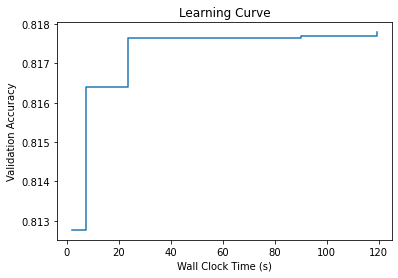

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(
    filename="flaml_log.json", time_budget=120)

plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Validation Accuracy")
plt.step(time_history, 1 - np.array(best_valid_loss_history), where="post")
plt.show()


## Hur skall vi köra den ny modellen 
1. preprocessa datat (nya kolumner)
    - proba och eller Kelly, ant hästar i loppet, favoriter, bara solklara favoriter
2. bestäm cat_features
3. Kör catboost eller flaml?
   - om flaml träna upp den
   - 

In [107]:
remove_garbage()